# Plotting all Figures
## File layout:

#### 1. Load all the measurement data and the EPR simulations
#### 2. Compare the measurement data with EPR results for the resonator and the qubit frequencies
#### 3. Use scqubits package to extract energy parameters of the device
#### 4. Time to compare the measurement data along with EPR and lumped method results

This notebook prepared by Figen Yilmaz.

# Initialization

In [2]:
import os
import numpy as np
import h5py
import json
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import scqubits as scq
from scqubits import HilbertSpace, ParameterSweep

from IPython.display import set_matplotlib_formats

from config import base_dir
from utils import get_data_folders
from utils import interp_fr
from utils import fig_prepare
from utils import asymmetric_lorentzian, double_asymmetric_lorentzian

# Create directory for figures if it doesn't exist
output_dir = "outputs/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function used to analyse parameter sweeps
def get_sweep_transition(sweep, initial_state, final_state):
    transitions = sweep[:].transitions(initial=initial_state)
    final_states = [transitions[0][i][-1] for i in range(len(transitions[0]))]
    idx = final_states.index(final_state)
    return transitions[1][idx]

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D

class HandlerLine2DWithMarkersize(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        handle = super().create_artists(legend, orig_handle,
                                        xdescent, ydescent, width, height, fontsize, trans)
        handle.set_markerfacecolor(handle.get_markeredgecolor())
        handle.set_markersize(30)  # Set the desired marker size in the legend
        return handle
    

import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D

class HandlerLine2DWithMarkersize(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        handles = super().create_artists(legend, orig_handle,
                                         xdescent, ydescent, width, height, fontsize, trans)
        for handle in handles:
            handle.set_markerfacecolor(handle.get_markeredgecolor())
            handle.set_markersize(4)  # Set the desired marker size in the legend
        return handles

In [4]:
import matplotlib.pyplot as plt

# Ensure font sizes are large enough to read
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

colors = {
    "red": "#ff4500",
    "green": "#00cc99",
    "yellow": "#FED100",
    "black": "#333333",
    "purple": "#836fff",
    "blue": "#127CB3"
}

# Load data

In [5]:
## Here, we load all the measurement data. 
with open('MeasurementData.npy', 'rb') as f:
    chi = np.load(f)
    results_x_fq = np.load(f)
    results_x_fr0 = np.load(f)
    results_x_fr1 = np.load(f)
    results_x_chi = np.load(f)
    results_y_fq = np.load(f)
    results_y_fr0 = np.load(f)
    results_y_fr1 = np.load(f)
    results_y_chi = np.load(f)

In [6]:
# Let's sort the experiment data
idx_fq = np.argsort(results_x_fq)
idx_fr0 = np.argsort(results_x_fr0)
idx_fr1 = np.argsort(results_x_fr1)
idx_chi = np.argsort(results_x_chi)

results_x_fq = results_x_fq[idx_fq]
results_y_fq = results_y_fq[idx_fq]
results_x_fr0 = results_x_fr0[idx_fr0]
results_y_fr0 = results_y_fr0[idx_fr0]
results_x_fr1 = results_x_fr1[idx_fr1]
results_y_fr1 = results_y_fr1[idx_fr1]
results_x_chi = results_x_chi[idx_chi]
results_y_chi = results_y_chi[idx_chi]

In [7]:
# we extracted the zero and the half flux values from the measurement data
amp_zero_flux = 0.15e-3 # the zero-flux value from measurement, unit is mA
amp_half_flux = -8.816e-3 # the half-flux value from measurement, unit is mA

# the measurements data are in current, we convert the currents to the phis
m_phis = ((results_x_chi[idx_chi]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2) 

_flux = ((results_x_fq[idx_fq]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)

# here, we convert the flux to the phis on the x-axis. This is also measurement data
flux_fr0 = ((results_x_fr0[idx_fr0]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)
flux_fr1 = ((results_x_fr1[idx_fr1]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)

# here, we load the EPR results. 
with open('EPR_simulations_data2.npy', 'rb') as f:
    chis = np.load(f)
    freq_qubit = np.load(f)
    freq_res = np.load(f)
    phis = np.load(f)

## Plotting the experimental resonator and the qubit frequencies with EPR results

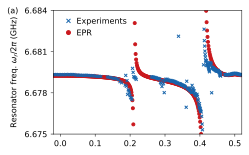

In [8]:
# Plotting the resonator frequency with EPR results
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
#ax.set_xlabel(r'External flux, $\Phi_{ext}/\Phi_0$')

# Set y-axis label and adjust its position
plt.ylabel('', labelpad=6.5)
ax.set_ylabel(r'Resonator freq. $\omega_r/2\pi$ (GHz)')

_flux = ((results_x_fq[idx_fq]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)

fig.subplots_adjust(bottom=0.10, top=0.96, left=0.19, right=0.96, wspace=0.4, hspace=0.4)

# Assuming 'line_exp' is the Line2D object for your experiments plot
line_exp, = ax.plot(flux_fr0, results_y_fr0[idx_fr0]*1e-9, linestyle="", marker="x", markersize=3.0, 
          color=plt.cm.Blues(0.8), label=r"Experiments", zorder=2) # Measuremental data

# Assuming 'line_epr' is the Line2D object for your EPR plot
line_epr, = ax.plot(phis, freq_res+0.01095, color=plt.cm.Reds(0.75), markersize=3, linestyle="", 
        marker="o", label=r"EPR", zorder=1) # EPR results

fig.set_size_inches(3.40457, 2.0)
font = {'size': 8}
mpl.rc('font', **font)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.set_yticks([6.675, 6.678, 6.681, 6.684])
ax.set_ylim(6.675,6.684)
ax.set_xlim(-0.02,0.52)
fig.text(0.0017, 0.94, '(a)')

# Add legend with adjusted marker size using the custom handler
ax.legend(frameon=False,handles=[line_exp, line_epr], handletextpad=0, fontsize=8, handler_map={type(line_epr): HandlerLine2DWithMarkersize()})
fig.savefig('ResonatorFrequency_vs_externalflux-EPRandMeasurementData.pdf', dpi=200)
plt.show()

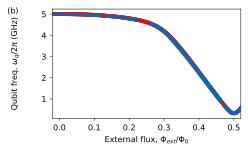

In [9]:
# Plotting the qubit frequency with EPR results
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
ax.set_xlabel(r'External flux, $\Phi_{ext}/\Phi_0$')

# Set y-axis label and adjust its position
plt.ylabel('', labelpad=22)

ax.set_ylabel(r'Qubit freq. $\omega_q/2\pi$ (GHz)')

_flux = ((results_x_fq[idx_fq]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)

fig.subplots_adjust(bottom=0.21, top=0.97, left=0.19, right=0.96, wspace=0.4, hspace=0.4)

# Assuming 'line_exp' is the Line2D object for your experiments plot
line_exp, = ax.plot(_flux, results_y_fq[idx_fq]*1e-9, linestyle="", marker="x", markersize=3.0, 
                    color=plt.cm.Blues(0.8), label=r"Experiments", zorder=3)

# Assuming 'line_epr' is the Line2D object for your EPR plot
line_epr, = ax.plot(phis, freq_qubit, color=plt.cm.Reds(0.75), markersize=3, linestyle="", 
                    marker="o", label="EPR", zorder=2)

fig.set_size_inches(3.40457, 2.0)
font = {'size': 8}
mpl.rc('font', **font)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.set_yticks([1.0, 2.0, 3.0, 4.0, 5.0])
ax.set_xlim(-0.02, 0.52)
fig.text(0.005, 0.94, '(b)')

fig.savefig('QubitFrequency_vs_externalflux-EPRandMeasurementData.pdf', dpi=200)
plt.show()

# Fit Fluxonium model from SCQubits

## Fit fluxonium model to extracted qubit frequencies

In [10]:
## Here, we fixed the EC, g and the resonator frequency values
EC = 0.943 # unit is in GHz, calculated by Maxwell capacitance matrix from the circuit design. 
E_osc = 6.6782 # unit is in GHz, this value is from the measurement data
g = 0.08515 # unit is in GHz, calculated by Maxwell capacitance matrix from the circuit design.

In [11]:
## EC and the g are calculated by Maxwell capacitance matrix, please check Appendix A for more detailed calculations.
def fun(x, amp_zero_flux, amp_half_flux, EJ, EL, EC=EC, E_osc=E_osc,g=g):
    fluxonium = scq.Fluxonium(EJ=EJ, EC=EC, EL=EL, flux=0, cutoff=20, 
                              truncated_dim=10, id_str="fluxonium")
    resonator = scq.Oscillator(E_osc=E_osc, truncated_dim=20, id_str="resonator")

    hilbertspace = scq.HilbertSpace([fluxonium, resonator])

    hilbertspace.add_interaction(
        g_strength=g,
        op1=fluxonium.n_operator,
        op2=resonator.creation_operator,
        add_hc=True
    )

    if isinstance(x, (np.ndarray, list)):
        flux_list = ((x-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)
        pname1 = "flux"

        paramvals_by_name = {pname1: flux_list}
        subsys_update_info = {pname1: [fluxonium]}

        def update_hilbertspace(param_sweep, flux):
            param_sweep.hilbertspace["fluxonium"].flux = flux

        sweep = ParameterSweep(
            hilbertspace=hilbertspace,
            paramvals_by_name=paramvals_by_name,
            update_hilbertspace=update_hilbertspace,
            evals_count=5,
            subsys_update_info=subsys_update_info,
            deepcopy=True
        )

        return  get_sweep_transition(sweep, (0,0), (1,0))
    else:
        flux = ((x-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)
        hilbertspace["fluxonium"].flux = flux
        hilbertspace.generate_lookup()
        return (hilbertspace.energy_by_dressed_index(1) - hilbertspace.energy_by_dressed_index(0))

In [12]:
## parameters are defined as (x, amp_zero_flux, amp_half_flux, EJ, EL)
popt,pcov = curve_fit(fun, 
                      results_x_fq[::10], #flux bias in A
                      results_y_fq[::10]*1e-9, #qubit freqs in GHz
                      p0=[0.15e-3, #initial guess for zero flux
                          -8.816e-3, #inital guess for hlf flux
                          3.9061, #initial guess for EJ, GHz
                          0.6303, #initial guess for EL, GHz
                         ], 
                      bounds=([0.0e-3, -8.85e-3, 3, 0.4], 
                              [0.2e-3, -8.78e-3, 5, 1.3]))

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/28 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/28 [00:00<?, ?it/s]

In [13]:
print(f"Fitted with scqubits: EJ={popt[2]} GHz, EL={popt[3]} GHz")

Fitted with scqubits: EJ=3.9222052288390983 GHz, EL=0.7483482964205618 GHz


In [14]:

fluxonium = scq.Fluxonium(EJ=popt[2], EL=popt[3], EC=EC, flux=0, cutoff=20, 
                          truncated_dim=10, id_str="fluxonium")
resonator = scq.Oscillator(E_osc=E_osc, truncated_dim=10, id_str="resonator")

hilbertspace = scq.HilbertSpace([fluxonium, resonator])

hilbertspace.add_interaction(
    g_strength=g,
    op1=fluxonium.n_operator,
    op2=resonator.creation_operator,
    add_hc=True
)

pname1 = "flux"
# flux_list = np.linspace(-0.1, 1.1, 1000)
flux_fr0 = ((results_x_fr0[idx_fr0]-popt[1])/(popt[0]-popt[1])-1)/(-2)
flux_fr1 = ((results_x_fr1[idx_fr1]-popt[1])/(popt[0]-popt[1])-1)/(-2)
_flux = np.unique(np.concatenate((flux_fr0, flux_fr1)))
flux_list = np.linspace(np.min(_flux), np.max(_flux), 200)

paramvals_by_name = {pname1: flux_list}
subsys_update_info = {pname1: [fluxonium]}

def update_hilbertspace(param_sweep, flux):
    param_sweep.hilbertspace["fluxonium"].flux = flux

sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=24,
    subsys_update_info=subsys_update_info,
    deepcopy=True
)


Bare spectra:   0%|          | 0/200 [00:00<?, ?it/s]

Bare spectra:   0%|          | 0/1 [00:00<?, ?it/s]

Dressed spectrum:   0%|          | 0/200 [00:00<?, ?it/s]

(-0.05, 0.53)

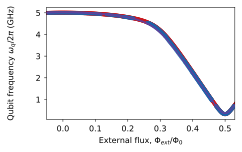

In [15]:
# Plotting the qubit frequency with EPR results along with the fit
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
ax.set_xlabel(r'External flux, $\Phi_{ext}/\Phi_0$')

# Set y-axis label and adjust its position
plt.ylabel('', labelpad=20)
ax.set_ylabel(r'Qubit frequency $\omega_q/2\pi$ (GHz)')

_flux = ((results_x_fq[idx_fq]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)

fig.subplots_adjust(bottom=0.19, top=0.97, left=0.19, right=0.96, wspace=0.4, hspace=0.4)

# Assuming 'line_exp' is the Line2D object for your experiments plot
line_exp, = ax.plot(_flux, results_y_fq[idx_fq]*1e-9, linestyle="", marker="x", markersize=3.0, 
                    color=plt.cm.Blues(0.8), label=r"Experiments", zorder=3)

# Assuming 'line_epr' is the Line2D object for your EPR plot
line_epr, = ax.plot(phis, freq_qubit, color=plt.cm.Reds(0.75), markersize=3.0, linestyle="", 
                    marker="o", label="EPR", zorder=2)

# Assuming 'line_lumped' is the Line2D object for your Lumped plot
line_lumped = ax.plot(flux_list, get_sweep_transition(sweep,(0,0), (1,0)), color=plt.cm.Purples(0.8),
        markersize=2, linestyle="", marker="2", label='Lumped', zorder=3)

fig.set_size_inches(3.40457, 2.0)
font = {'size': 8}
mpl.rc('font', **font)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.set_yticks([1.0, 2.0, 3.0, 4.0, 5.0])
ax.set_xlim(-0.050, 0.53)

(-0.052, 0.53)

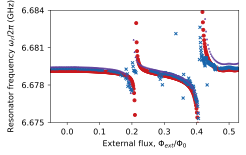

In [16]:
# Plotting the resonator frequency with EPR results along with the fit
fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
ax.set_xlabel(r'External flux, $\Phi_{ext}/\Phi_0$')

# Set y-axis label and adjust its position
plt.ylabel('', labelpad=6.5)

ax.set_ylabel(r'Resonator frequency $\omega_r/2\pi$ (GHz)')

_flux = ((results_x_fq[idx_fq]-amp_half_flux)/(amp_zero_flux-amp_half_flux)-1)/(-2)

fig.subplots_adjust(bottom=0.19, top=0.97, left=0.19, right=0.96, wspace=0.4, hspace=0.4)

# Assuming 'line_epr' is the Line2D object for your EPR plot
line_epr, = ax.plot(phis, freq_res++0.01084, color=plt.cm.Reds(0.75), markersize=3.0, linestyle="", 
        marker="o", label=r"EPR", zorder=1) # EPR results

# Assuming 'line_exp' is the Line2D object for your experiments plot
line_exp, = ax.plot(flux_fr0, results_y_fr0[idx_fr0]*1e-9, linestyle="", marker="x", markersize=3.0, 
          color=plt.cm.Blues(0.8), label=r"Experiments", zorder=2) # Measuremental data

# Assuming 'line_lumped' is the Line2D object for your Lumped plot
line_lumped = ax.plot(flux_list, get_sweep_transition(sweep,(0,0), (0,1)), color=plt.cm.Purples(0.8),
        markersize=2.0, linestyle="", marker="2", label='Lumped', zorder=3)

fig.set_size_inches(3.40457, 2.0)
font = {'size': 8}
mpl.rc('font', **font)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

ax.set_yticks([6.675, 6.678, 6.681, 6.684])
ax.set_ylim(6.675,6.684)
ax.set_xlim(-0.052,0.53)

## Plotting the dispersive shift versus external flux

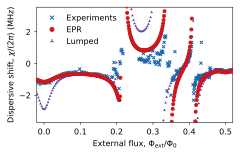

In [17]:
from matplotlib.legend_handler import HandlerLine2D
# The chis from the measurement data compared with pyEPR simulations
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlabel(r'External flux, $\Phi_{ext}/\Phi_0$')
ax.set_ylabel(r'Dispersive shift, $\chi/(2\pi)$ (MHz)')

fig.subplots_adjust(bottom = 0.19, top=0.99, left=0.16, right=0.96, wspace=0.4, hspace=0.4)

class HandlerLine2DWithMarkersize(HandlerLine2D):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        handles = super().create_artists(legend, orig_handle,
                                         xdescent, ydescent, width, height, fontsize, trans)
        for handle in handles:
            handle.set_markerfacecolor(handle.get_markeredgecolor())
            handle.set_markersize(4)  # Set the desired marker size in the legend
        return handles

    
fig.set_size_inches(3.40457, 2.0)
font = {'size' : 8}
mpl.rc('font', **font)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(width=0.5, which='both')
ax.tick_params(length=2.5, which='major')
ax.tick_params(length=1.5, which='minor')

# Assuming 'line_exp' is the Line2D object for your experiments plot
line_exp = ax.plot(m_phis, results_y_chi[idx_chi]*1e-6, linestyle="", marker="x", markersize=3.0, 
        color=plt.cm.Blues(0.8), label=r"Experiments", zorder=2)
# Assuming 'line_epr' is the Line2D object for your EPR plot
line_epr = ax.plot(phis, chis/2, color=plt.cm.Reds(0.75), markersize=3.0, linestyle="", 
                    marker="o", label="EPR", zorder=3)
# Assuming 'line_lumped' is the Line2D object for your Lumped plot
line_lumped = ax.plot(flux_list, 1000*(-get_sweep_transition(sweep, 
        (0,0), (0,1))+ get_sweep_transition(sweep, (1,0), (1,1)))/2, color=plt.cm.Purples(0.8),
        markersize=2.5, linestyle="", marker="2", label='Lumped', zorder=1)

ax.set_ylim(-3.7055,3.55)
ax.set_xlim(-0.02,0.52)

# Add legend with adjusted marker size using the custom handler
ax.legend(frameon=False,handles=[line_exp[0], line_epr[0], line_lumped[0]], fontsize=8, handler_map={type(line_epr[0]): HandlerLine2DWithMarkersize()})
fig.savefig('Chi_Experiment-EPR-Lumped_Data.pdf', dpi=200)